In [3]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
# Set up the tensorflow session as same as the keras session
K.set_session(sess)

In [4]:
# Design the network architecture using Keras
# downconv + flatconv + downconv + flatconv + flatconv + upconv + flatconv + upconv + flatconv + flatconv
from tensorflow.python.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model

inputs = Input(shape=(256, 256, 3))
x = Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
outputs = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
model =Model(inputs, outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 64)      36928     
__________

In [5]:
# Import the dataset
import pickle
with open('train_data', 'rb') as file:
    train_images, train_outputs = pickle.load(file)
print('Dataset dimensions', train_images.shape, train_outputs.shape)
with open('test_data', 'rb') as file:
    test_images, test_outputs = pickle.load(file)
# Normalize the pixel values
train_images = train_images.astype('float32') / 255
train_outputs = train_outputs.astype('float32') / 255
test_images = test_images.astype('float32') / 255
test_outputs = test_outputs.astype('float32') / 255

Dataset dimensions (298, 256, 256, 3) (298, 256, 256, 3)


In [8]:
from matplotlib import pyplot as plt
def evaluate(trained_model, real_image, expected_image):
    """Evaluate the model output for 'real_image' as the input.
    Also, display display all the images side by side"""
    test_input = np.expand_dims(real_image, 0)
    pred_output = trained_model.predict(test_input)
    f, axarr = plt.subplots(1,3, figsize=(12,12))
    axarr[0].imshow(real_image, interpolation='bilinear')
    axarr[0].set_title('Real image')
    axarr[1].imshow(pred_output[0], interpolation='bilinear')
    axarr[1].set_title('Model output')
    axarr[2].imshow(expected_image, interpolation='bilinear')
    axarr[2].set_title('Program output')
    plt.show()

In [9]:
# Train the model for 50 epochs with all the images in the 
# training dataset
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
gpu_list = [x.name for x in local_device_protos if x.device_type == 'GPU']
if len(gpu_list) > 0:
    # Don't try to train the model if no gpus are available
    model.fit(train_images, train_outputs, epochs=50, batch_size=16)
    model.save('trained_model')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


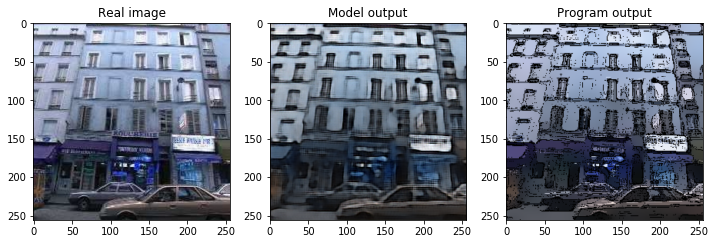

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


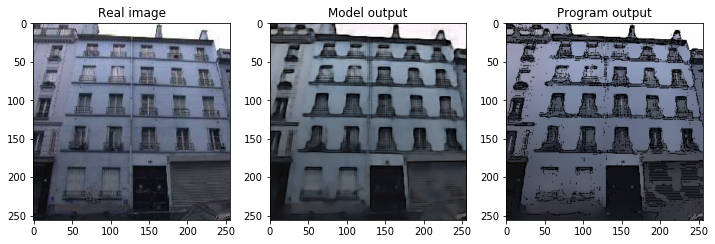

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


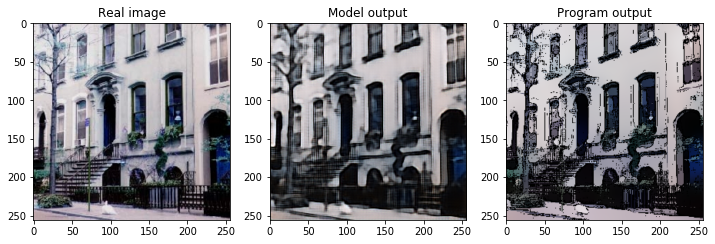

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


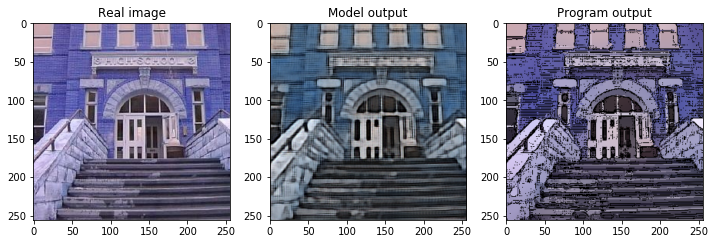

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


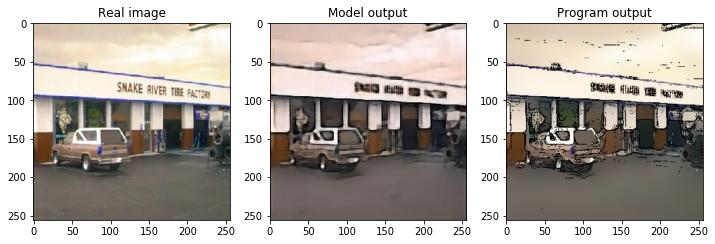

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


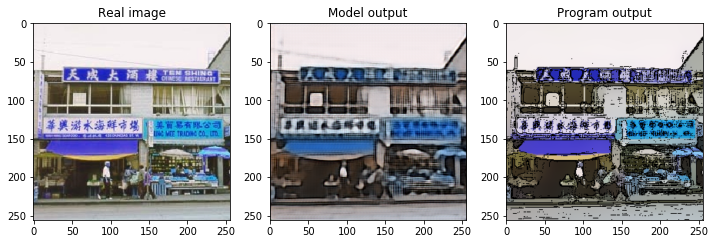

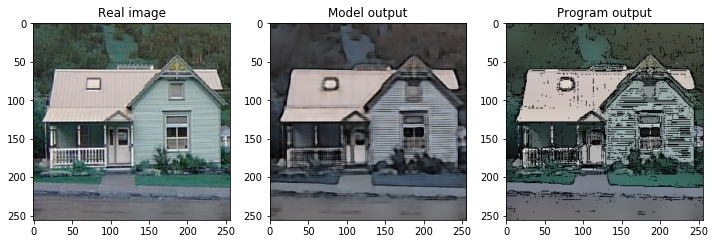

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


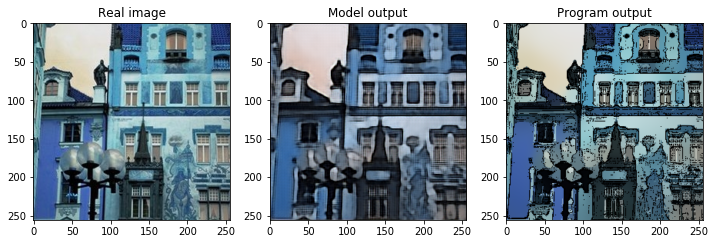

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


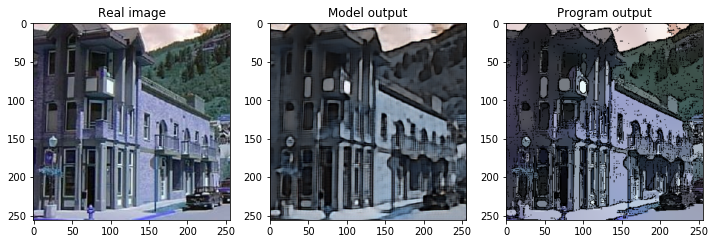

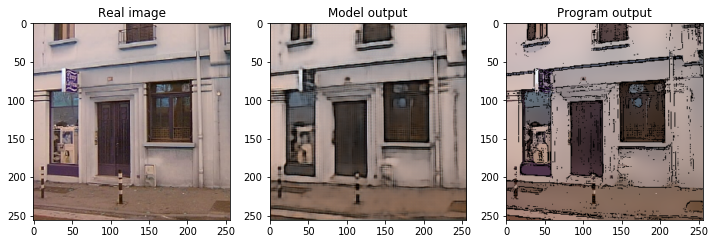

In [10]:
# Train the model on a gpu and load the trained model
from tensorflow.python.keras.models import load_model
trained_model = load_model('trained_model')
for image, output in zip(test_images, test_outputs):
    evaluate(trained_model, image, output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


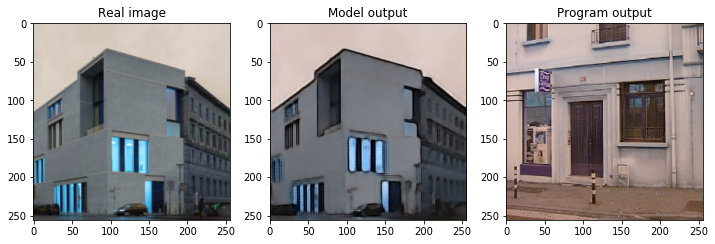

In [12]:
import cv2
rand_img = cv2.imread('/home/abhilash/Downloads/rand_img.jpg')
rand_img = rand_img.astype('float32') / 255
evaluate(trained_model, rand_img, test_images[9])